In [1]:
pip install pandas scikit-learn opencv-python tqdm matplotlib "numpy<2.0,>=1.23.5" seaborn  


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available())

print("\nLocal devices:")
print(device_lib.list_local_devices())


TF version: 2.10.0
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True

Local devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18130454092736055888
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9901703168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8316627276549760280
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [3]:
# Cell 1: Imports and Data Generator Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    GlobalAveragePooling2D, Add, Activation, BatchNormalization,
    DepthwiseConv2D, Reshape, LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
BATCH_SIZE = 32  # Increased from 16 to 32 for transformer efficiency
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 5
LEARNING_RATE = 0.0001  # Slightly lower for transformer training
EPOCHS = 50
WEIGHT_DECAY = 0.0004  # L2 regularization
DROPOUT_RATE = 0.5

# Dataset directory
BASE_DATA_DIR = r'F:\Program Files\CSE445_Project\CSE445_Project_CustomCNN\skin_cancer_dataset_final'
# ---------------------

# Define Paths
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')

# Setup ImageDataGenerator with aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
print("Loading Data Generators...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Data generators loaded: {train_generator.num_classes} classes")
print(f"Total training images: {train_generator.samples}")

Loading Data Generators...
Found 19055 images belonging to 5 classes.
Found 2427 images belonging to 5 classes.
Found 1253 images belonging to 5 classes.
✅ Data generators loaded: 5 classes
Total training images: 19055


In [ ]:
#  Cell 2: Define Hybrid CNN-Transformer Model Architecture

def residual_block(x, filters, kernel_size=3):
    """Residual block with two 3x3 conv layers and skip connection"""
    res = x
    x = Conv2D(filters, kernel_size, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    x = Add()([x, res])
    x = Activation('relu')(x)
    return x


def mbconv_block(x, expansion_factor, filters, kernel_size=3):
    """Mobile Inverted Residual (MBConv) block"""
    in_filters = x.shape[-1]
    expanded_filters = int(in_filters * expansion_factor)
    
    
    if expansion_factor != 1:
        x_exp = Conv2D(expanded_filters, 1, padding='same',
                       kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
        x_exp = BatchNormalization()(x_exp)
        x_exp = Activation('relu')(x_exp)
    else:
        x_exp = x
    
    
    x_dw = DepthwiseConv2D(kernel_size, padding='same',
                           depthwise_regularizer=regularizers.l2(WEIGHT_DECAY))(x_exp)
    x_dw = BatchNormalization()(x_dw)
    x_dw = Activation('relu')(x_dw)
    
    
    x_proj = Conv2D(filters, 1, padding='same',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x_dw)
    x_proj = BatchNormalization()(x_proj)
    
    
    if int(in_filters) == filters:
        x_proj = Add()([x_proj, x])
    
    x_out = Activation('relu')(x_proj)
    return x_out


def transformer_block(x, num_heads, key_dim):
    """ViT-style Transformer block with multi-head self-attention"""
    h = int(x.shape[1])
    w = int(x.shape[2])
    c = int(x.shape[3])
    
    
    x_seq = Reshape((h * w, c))(x)
    
    
    x_norm1 = LayerNormalization()(x_seq)
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=0.1
    )(x_norm1, x_norm1)
    attn_output = Dropout(DROPOUT_RATE)(attn_output)
    x2 = Add()([attn_output, x_seq])  
    

    x_norm2 = LayerNormalization()(x2)
    ffn = Dense(c, activation='relu',
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x_norm2)
    ffn = Dense(c, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(ffn)
    x3 = Add()([ffn, x2])  
    
    
    x_out = Reshape((h, w, c))(x3)
    return x_out


def create_hybrid_model(input_shape, num_classes):
    """Build Hybrid CNN-Transformer Model"""
    inputs = Input(shape=input_shape)
    

    x = Conv2D(32, 3, strides=2, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, 3, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    
    x = residual_block(x, filters=64)
    
    
    
    x = mbconv_block(x, expansion_factor=4, filters=128)

    
    
    x = MaxPooling2D(pool_size=2)(x) 
    x = Conv2D(128, 1, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
   
    
  
    x = MaxPooling2D(pool_size=2)(x)  
    
    
   
    x = mbconv_block(x, expansion_factor=4, filters=256)
    
    
    x = MaxPooling2D(pool_size=2)(x)  
    
    
    
    x = transformer_block(x, num_heads=4, key_dim=64)
  
    
   
    x = transformer_block(x, num_heads=4, key_dim=64)
   
    
   
    x = GlobalAveragePooling2D()(x)
    x = Dropout(DROPOUT_RATE)(x)
    outputs = Dense(num_classes, activation='softmax',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="HybridCNNTransformer")
    return model



model = create_hybrid_model(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    num_classes=NUM_CLASSES
)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "HybridCNNTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                              

In [5]:

# Cell 3: Train the Hybrid Model

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_hybrid_skin_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Start Training
print("\n### 🚀 Starting Hybrid Model Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

print("\n✅ Training Complete. Best model saved to 'best_hybrid_skin_model.h5'.")



### 🚀 Starting Hybrid Model Training...
Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 2.1273 - accuracy: 0.4993
Epoch 1: val_accuracy improved from -inf to 0.62708, saving model to best_hybrid_skin_model.h5
595/595 [==============================] - 1240s 2s/step - loss: 2.1273 - accuracy: 0.4993 - val_loss: 1.7836 - val_accuracy: 0.6271 - lr: 1.0000e-04
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 1.8620 - accuracy: 0.5964
Epoch 2: val_accuracy did not improve from 0.62708
595/595 [==============================] - 503s 845ms/step - loss: 1.8620 - accuracy: 0.5964 - val_loss: 2.1697 - val_accuracy: 0.5225 - lr: 1.0000e-04
Epoch 3/50
595/595 [==============================] - ETA: 0s - loss: 1.7595 - accuracy: 0.6317
Epoch 3: val_accuracy did not improve from 0.62708
595/595 [==============================] - 493s 827ms/step - loss: 1.7595 - accuracy: 0.6317 - val_loss: 1.8554 - val_accuracy: 0.5954 - lr: 1.0000e-04
Epoch 4/50
595/595 [

✅ Loaded best model weights.

### 📉 Generating Predictions on Test Set...
40/40 [==============================] - 38s 902ms/step

### 📋 Classification Report
                               precision    recall  f1-score   support

            actinic_keratoses     0.4828    0.6667    0.5600        42
         basal_cell_carcinoma     0.7385    0.7164    0.7273        67
benign_keratosis-like_lesions     0.4789    0.7183    0.5746       142
             melanocytic_Nevi     0.9301    0.7599    0.8364       858
                     melanoma     0.4537    0.6806    0.5444       144

                     accuracy                         0.7406      1253
                    macro avg     0.6168    0.7084    0.6486      1253
                 weighted avg     0.7990    0.7406    0.7581      1253


### 📊 Confusion Matrix


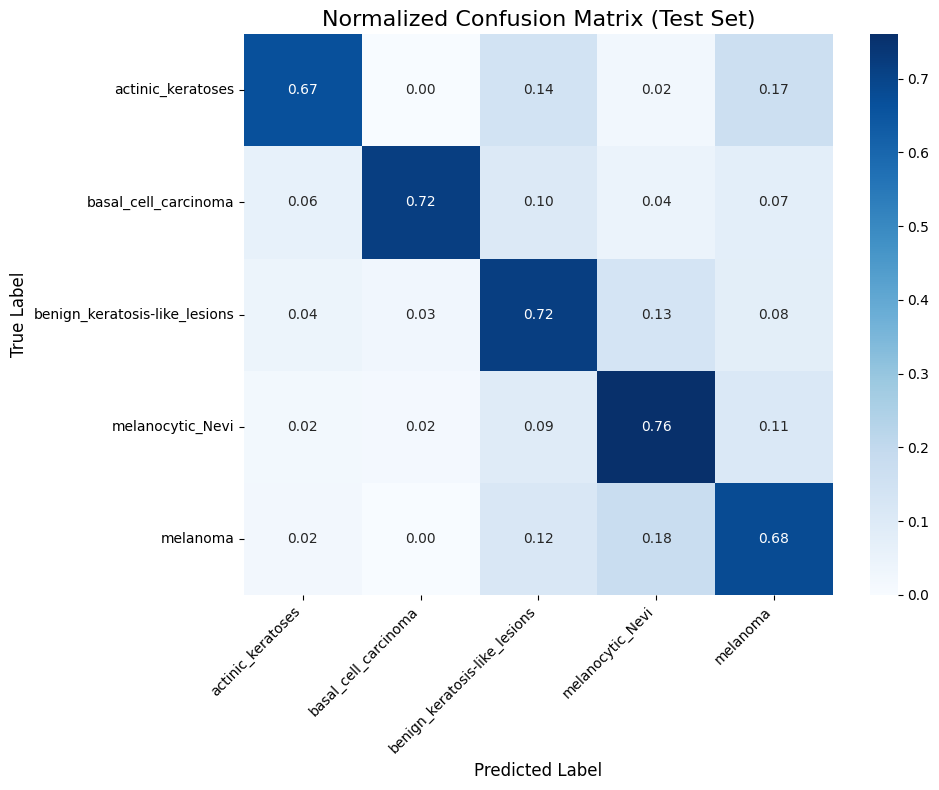


### 📈 ROC AUC Score (Multi-class One-vs-Rest)


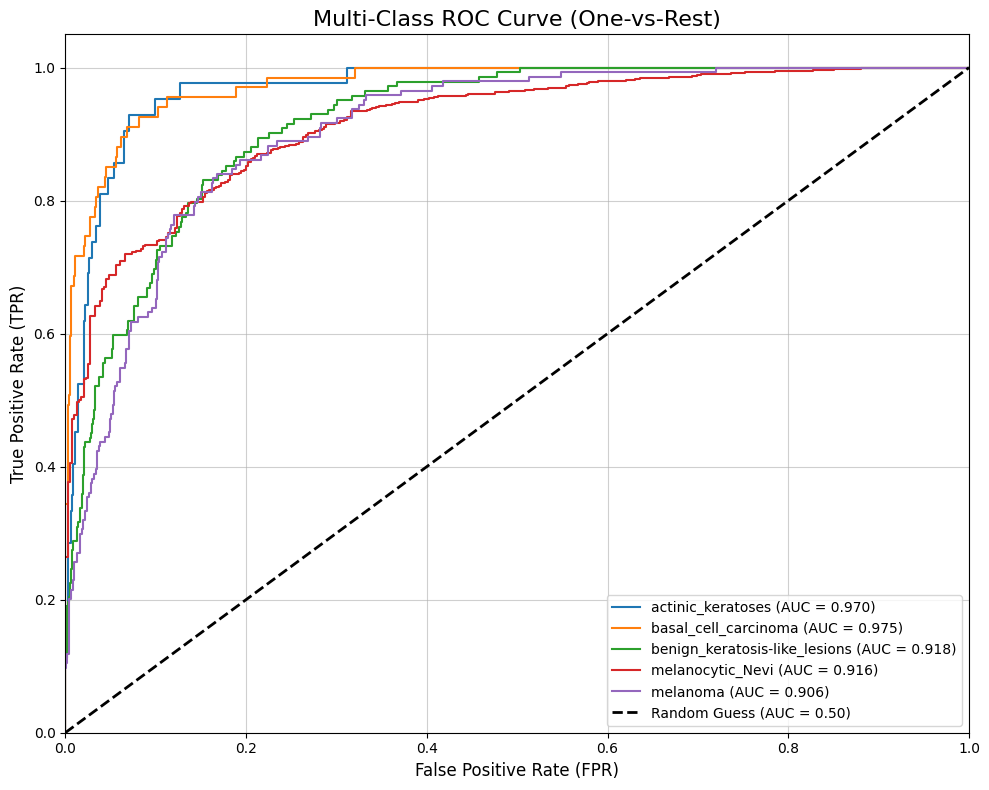

In [6]:

# Cell 4: Evaluate on Test Set

# Load best weights
try:
    model.load_weights('best_hybrid_skin_model.h5')
    print("✅ Loaded best model weights.")
except Exception as e:
    print(f"⚠️ Error loading weights: {e}")

# Generate Predictions
print("\n### 📉 Generating Predictions on Test Set...")
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
test_generator.reset()
Y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

Y_pred = np.argmax(Y_pred_proba, axis=1)
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n### 📋 Classification Report")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion Matrix
print("\n### 📊 Confusion Matrix")
cm = confusion_matrix(Y_true, Y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curve
print("\n### 📈 ROC AUC Score (Multi-class One-vs-Rest)")
Y_true_binarized = label_binarize(Y_true, classes=np.arange(len(class_labels)))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Multi-Class ROC Curve (One-vs-Rest)', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

✅ Loaded best weights for prediction.


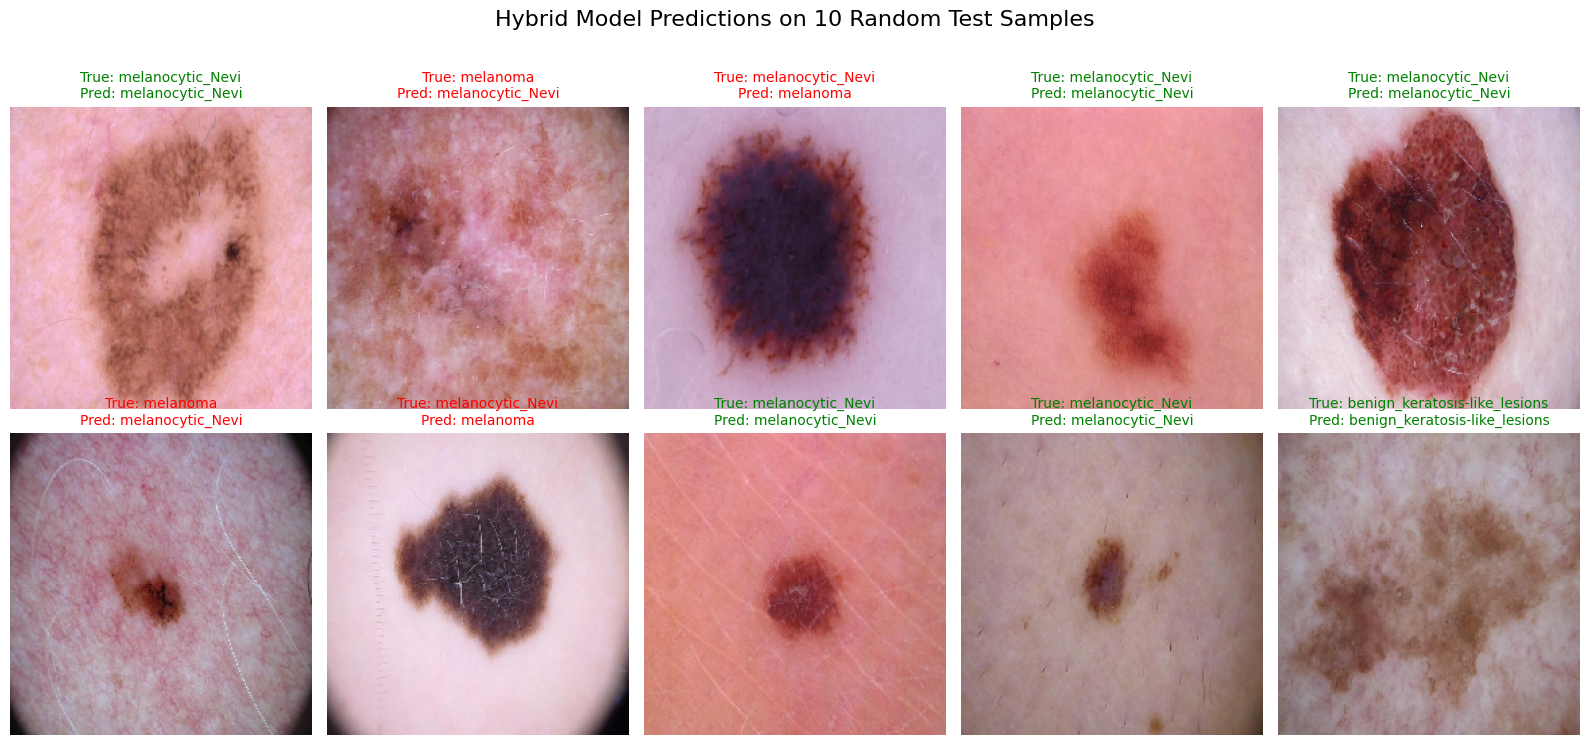

In [9]:

# Cell 5: Visual Prediction Test (10 Random Samples)

from tensorflow.keras.preprocessing import image

NUM_SAMPLES = 10

# Load best model weights
try:
    model.load_weights('best_hybrid_skin_model.h5')
    print("✅ Loaded best weights for prediction.")
except Exception as e:
    print(f"⚠️ Error: {e}")

# Get test data
test_filepaths = test_generator.filepaths
test_true_indices = test_generator.classes
class_names = list(test_generator.class_indices.keys())
total_test_samples = len(test_filepaths)

# Sample random images
np.random.seed(42)
sampled_indices = np.random.choice(total_test_samples, size=NUM_SAMPLES, replace=False)

sampled_images = []
sampled_true_labels_indices = []

for i in sampled_indices:
    path = os.path.join(test_generator.directory, test_filepaths[i])
    img = image.load_img(path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array_rescaled = img_array / 255.0
    sampled_images.append(img_array_rescaled)
    sampled_true_labels_indices.append(test_true_indices[i])

sampled_batch = np.array(sampled_images)

# Predict
predictions_proba = model.predict(sampled_batch, verbose=0)
predictions_indices = np.argmax(predictions_proba, axis=1)

# Visualize
plt.figure(figsize=(16, 8))

for i in range(NUM_SAMPLES):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sampled_batch[i])
    plt.axis('off')
    
    true_label = class_names[sampled_true_labels_indices[i]]
    predicted_label = class_names[predictions_indices[i]]
    color = 'green' if true_label == predicted_label else 'red'
    
    title = f"True: {true_label}\nPred: {predicted_label}"
    plt.title(title, color=color, fontsize=10)

plt.suptitle(f"Hybrid Model Predictions on {NUM_SAMPLES} Random Test Samples", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




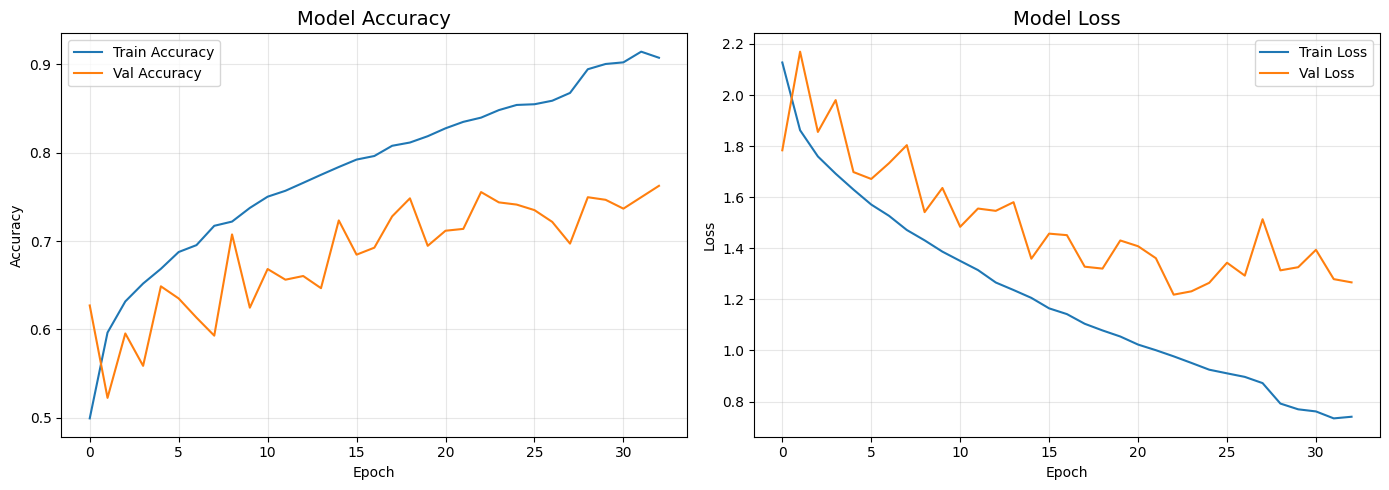

In [ ]:
# Cell 6: Training History Visualization

# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()